In [10]:
#encoding. word encoding
import codecs
#finds all pathnames matching a pattern, like regex
import glob
#log events for libraries
import logging
#concurrency
import multiprocessing
#dealing with operating system , like reading file
import os
#pretty print, human readable
import pprint
#regular expressions
import re
#natural language toolkit
import nltk
#word 2 vec
import gensim.models.word2vec as w2v
#dimensionality reduction
import sklearn.manifold
#math
import numpy as np
#plotting
import matplotlib.pyplot as plt
#parse dataset
import pandas as pd
#visualization
import seaborn as sns
#Clear cell output from IPython
from IPython.display import clear_output
#make copies of data structures
from copy import deepcopy
#Logistic regression learning model
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
#Get ordered dictionaries
import collections
#Show the results of our logistic regression
#import statsmodels.api as sm

In [11]:
#filepaths and default settings. Change values here
positive_set = './AAA_InterPro_reviewed.fasta'
generic_proteins = './uniprot_sprot.fasta'
aaa2vec_NN = "aaa2vec_1745pos_1745neg_contextsize7.w2v"

#Choose the number of examples you would like to use for the training positive, training negative,
#testing positive, and testing negative examples
#70/30 split between training set and test set
numPos = 1745
numNeg = 1745
numTestPos = 700
numTestNeg = 700

#Build our word2vec model
#define hyperparameters
#Dimensionality of the resulting word vectors.
#more dimensions mean more traiig them, but more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 1

# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#rate 0 and 1e-5 
#how often to use
downsampling = 1e-3

In [12]:
#Pass the path of a fasta file to process file and get an orderedDict back
def fastaToDict(filepath):
    proteinDict = collections.OrderedDict()
    with open(filepath, 'r') as f:
        currentKey = "n/a"
        currentSeq = ""
        i = 0
        for line in f:
            #This portion of the code is responsible for printing the values
            if (i % 10000 == 0):
                clear_output(wait=True)    
                print ("Processing hit %i"%(i))
            #If we're at the beginning of the FASTA file
            if currentKey == "n/a" and line[0] == ">":
                currentKey = line[1:].rstrip()

            #When we've finishing scanning our current training example  
            elif line[0] == ">":
                proteinDict[currentKey] = currentSeq
                currentKey = line[1:].strip()
                currentSeq = ""
                i += 1
            else:
                currentSeq = currentSeq + line.rstrip()

    #The last entry
    proteinDict[currentKey] = currentSeq
    
    #return the dict
    print('Processed a total of %i sequences'%(i))
    return proteinDict

In [13]:
#Input: Ordered Dictionary of protein sequences, output: tokenized words of protein sequences
def tokenizeProteins(proteinDict):
    tokensMapping = {}
    proteinName = ''
    
    for protein in proteinDict.keys():
        proteinName = protein
        sentence_raw = deepcopy(proteinDict[proteinName]) 
        sentence_length = len(sentence_raw)
        
        for j in range(3):
            sentence_tokenized = []
            temp_string = sentence_raw[j:]
            n = len(temp_string)//3
            unit = []
            for i in range(n):
                unit = sentence_raw[(i*3)+j:(((i+1)*3)+j)]
                sentence_tokenized.append(unit)
            tokensMapping[proteinName+str(j)]=sentence_tokenized
    
    proteinTokens = []
    for key in tokensMapping:
        proteinTokens.append(tokensMapping[key])
    return proteinTokens

In [14]:
def generateTraining(positiveDict, numPos, negativeDict, numNeg):
    combinedDict = collections.OrderedDict()
    Y = []
    i = 0
    for item in positiveDict:
        if (i == numPos):
            break
        Y.append(1)
        combinedDict[item] = positiveDict[item]
        i += 1
    j = 0
    for item in negativeDict:
        if (j == numNeg):
            break
        Y.append(0)
        combinedDict[item] = negativeDict[item]
        j+=1
    return combinedDict,Y

In [15]:
def generateTest(positiveDict, numPos, numTestPos, negativeDict, numNeg, numTestNeg):
    combinedTestDict = collections.OrderedDict()
    Y = []
    i = 0
    for item in positiveDict:
        if (i == numPos + numTestPos):
            break
        if (i < numPos):
            i +=1
            continue
        else:
            Y.append(1)
            combinedTestDict[item] = positiveDict[item]
        i += 1
    j = 0
    for item in negativeDict:
        if (j == numNeg + numTestNeg):
            break
        if (j < numNeg):
            j+=1
            continue
        else:
            Y.append(0)
            combinedTestDict[item] = negativeDict[item]
        j+=1
    return combinedTestDict,Y

In [16]:
def generateX(proteinTokens, vec):
    #We have tokens of our "positive"
    i = 0
    X = []
    while (i < len(proteinTokens)-1):
      frame1 = proteinTokens[i]
      frame2 = proteinTokens[i+1]
      frame3 = proteinTokens[i+2]
      total = frame1+frame2+frame3
      index = i//3
      currentSum = np.zeros((300,))
      num_words = 1  
      for word in total:
        if word in vec:
            num_words +=1    
            currentSum = np.add(currentSum,vec[word])
      X.append(np.divide(currentSum,num_words))
      i += 3
    return X

In [17]:
def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
           FP += 1
        if y_actual[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [18]:
positiveDict = fastaToDict(positive_set)

Processing hit 0
Processed a total of 2494 sequences


In [19]:
negativeDict = fastaToDict(generic_proteins)

Processing hit 560000
Processed a total of 563551 sequences


In [20]:
trainingSet,Ytrain = generateTraining(positiveDict, numPos, negativeDict, numNeg)

In [21]:
testSet,Ytest = generateTest(positiveDict, numPos, numTestPos, negativeDict, numNeg, numTestNeg)

In [22]:
testTokens = tokenizeProteins(testSet)
trainingTokens = tokenizeProteins(trainingSet)

In [14]:
aaa2vec = w2v.Word2Vec(
    sg=1,
    seed=1,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [15]:
aaa2vec.build_vocab(trainingTokens)

In [16]:
aaa2vec.train(trainingTokens, total_examples=aaa2vec.corpus_count, epochs=100)

(145778900, 145778900)

In [17]:
#save model
if not os.path.exists("trained"):
    os.makedirs("trained")
aaa2vec.save(os.path.join("trained", aaa2vec_NN))

In [23]:
#load model
aaa2vec = w2v.Word2Vec.load(os.path.join("trained", aaa2vec_NN))

In [24]:
Xtrain = generateX(trainingTokens,aaa2vec)

<ipython-input-16-a30099c907a6>:14: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if word in vec:
<ipython-input-16-a30099c907a6>:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  currentSum = np.add(currentSum,vec[word])


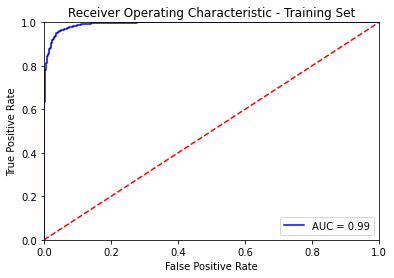

In [25]:
model = LogisticRegression()
model.fit(Xtrain,Ytrain)
#Ytrain_Pred=logistic_regression.predict(Xtrain)


# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(Xtrain)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Ytrain, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic - Training Set')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [26]:
Xtest = generateX(testTokens,aaa2vec)

<ipython-input-16-a30099c907a6>:14: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if word in vec:
<ipython-input-16-a30099c907a6>:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  currentSum = np.add(currentSum,vec[word])


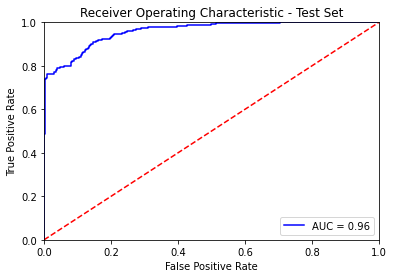

In [27]:
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(Xtest)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Ytest, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic - Test Set')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [47]:
Y_trainpred = model.predict(Xtrain)
Y_testpred = model.predict(Xtest)
train_stats = perf_measure(Ytrain, Y_trainpred)
test_stats = perf_measure(Ytest, Y_testpred)

In [48]:
print("The confusion matrix for the training set of data is the following in order --> TP,FP,TN,FN =")
print(train_stats)

The confusion matrix for the training set of data is the following in order --> TP,FP,TN,FN =
(1680, 87, 1658, 65)


In [49]:
print("The confusion matrix for the test set of data is the following in order --> TP,FP,TN,FN =")
print(test_stats)

The confusion matrix for the test set of data is the following in order --> TP,FP,TN,FN =
(645, 123, 577, 55)
